In [2]:
import healpy as hp
import bigfile
#from scipy import *
import numpy as np
from pylab import *
import os
from astropy.io import fits
from datetime import date
%matplotlib inline

In [3]:
######## check TT, Pk (z=0), Clkk (z=1) from class vs camb
ombh2 = 0.02247
omch2 = 0.11923

# LCDM parameters
A_s = 2.10732e-9
h=0.677
OmegaB = ombh2/h**2#0.046
OmegaM = omch2/h**2#0.309167
n_s = 0.96824
tau = 0.054 ## only for primary CMB, not used for now, for simplicity

### accuracy parameters
lmax=5000

In [10]:
##########################
####### class ############
##########################

## https://github.com/lesgourg/class_public/blob/master/explanatory.ini
# 1.a) list of output spectra requested:
# - 'tCl' for temperature Cls,
# - 'pCl' for polarization Cls,
# - 'lCl' for CMB lensing potential Cls,
# - 'nCl' (or 'dCl') for density number count Cls,
# - 'sCl' for galaxy lensing potential Cls,
# - 'mPk' for total matter power spectrum P(k) infered from gravitational potential,
# - 'dTk' (or 'mTk') for density transfer functions for each species,
# - 'vTk' for velocity transfer function for each species.

# import classy module
from classy import Class
# create instance of the class "Class"
def calc_cl(z_s):
    LambdaCDM = Class()
    LambdaCDM.set({'omega_b':ombh2,'omega_cdm':omch2,'h':h,'A_s':A_s,'n_s':n_s})
    LambdaCDM.set({'output':'mPk,sCl',
                   #'lensing':'yes',
                   'lensing':'no',
                   'P_k_max_1/Mpc':10.0,
                   'z_pk':0,
                   'reio_parametrization':'reio_none',
                   'l_switch_limber':100,
                   'selection':'dirac',
                   'selection_mean':z_s,
                   'l_max_lss':lmax,
                   'non linear':'halofit'
                  })

    LambdaCDM_linear = Class()
    LambdaCDM_linear.set({'omega_b':ombh2,'omega_cdm':omch2,'h':h,'A_s':A_s,'n_s':n_s})
    LambdaCDM_linear.set({'output':'mPk,sCl',
                   #'lensing':'yes',
                   'lensing':'no',
                   'P_k_max_1/Mpc':10.0,
                   'z_pk':0,
                   'reio_parametrization':'reio_none',
                   'l_switch_limber':100,
                   'selection':'dirac',
                   'selection_mean':z_s,
                   'l_max_lss':lmax,
                  })
    # run class
    LambdaCDM.compute()
    LambdaCDM_linear.compute()

    # get Clkk
    cls2=LambdaCDM.density_cl(lmax)
    ell=cls2['ell'][2:]
    clphiphi=cls2['ll'][0][2:]
    clkk=1.0/4 * (ell+2.0)*(ell+1.0)*(ell)*(ell-1.0)*clphiphi

    # get Clkk linear
    cls2_lin=LambdaCDM_linear.density_cl(lmax)
    ell=cls2_lin['ell'][2:]
    clphiphi_lin=cls2_lin['ll'][0][2:]
    clkk_lin=1.0/4 * (ell+2.0)*(ell+1.0)*(ell)*(ell-1.0)*clphiphi_lin
    return ell, clkk, clkk_lin

In [51]:
zs=1.0
fs=12
def gen_comp(zs,nc=512):
    f = bigfile.File('lensing_maps/WL-%.2f-N0512'%(zs))

    nside = f['kappa'].attrs['nside'][0] 
    zmin  = f['kappa'].attrs['zlmin'][0] 
    zmax  = f['kappa'].attrs['zlmax'][0] 
    #zstep = f['kappa'].attrs['zstep'][0] 
    zs    = f['kappa'].attrs['zs'][0] 

    # print('nside = ', nside)
    # print('redshifts = ', zs)

    lmax = min([1000,nside])#5000
    ell_sim = np.arange(lmax+1)
    # print (f['kappa'][:].shape)
    fn_cl='lensing_maps/kappa_cl_z%.2f.npz'%(zs)
    if not os.path.isfile(fn_cl):
        cl=hp.anafast(f['kappa'][:], lmax=lmax)
        np.savez(fn_cl, ell=ell_sim, cl = cl) 

    ####### load sim cl
    data=load(fn_cl)
    ell_sim, cl_sim=data['ell'], data['cl']

    ####### compute halofit curve
    fn_cl_camb = 'kappa_cl_camb_z%.2f.npz'%(zs)
    if not os.path.isfile(fn_cl_camb):
        ell, clkk, clkk_lin = calc_cl(zs)
        np.savez(fn_cl_camb, ell=ell, clkk = clkk, clkk_lin=clkk_lin)
    data=load(fn_cl_camb)
    ell, clkk, clkk_lin = data['ell'], data['clkk'], data['clkk_lin']

    ititle='zs=%s; nside=%i; nc=%i \n(%s)'%(zs,nside,nc,date.today())
    figure(0, figsize=(8,4))
    xscale('log');yscale('log');#xlim(2,2500)
    xlabel(r'$\ell$',fontsize=fs+2)
    ylabel(r'$[\ell(\ell+1)/2\pi]  C_\ell^\mathrm{kk}$',fontsize=fs+2)
    plot(ell,clkk_lin*ell*(ell+1)/2./pi,'c--',lw=3,alpha=0.5,label='linear')
    plot(ell,clkk*ell*(ell+1)/2./pi,'g-',lw=3,alpha=0.5,label='halofit')
    plot(ell_sim,cl_sim*ell_sim*(ell_sim+1)/2./pi,'k-',lw=1,alpha=0.6,label='HalfDome')
    legend(loc=0,frameon=0,fontsize=fs)
    title(ititle,fontsize=fs+4)
    show()
    
    hp.mollview(f['kappa'][:],title=ititle)#, min=-0.02, max=0.02)
    #fov = 5
    #hp.cartview(f['kappa'][:], lonra=[-fov/2, fov/2], latra=[-fov/2, fov/2], min=-0.3, max=0.3)


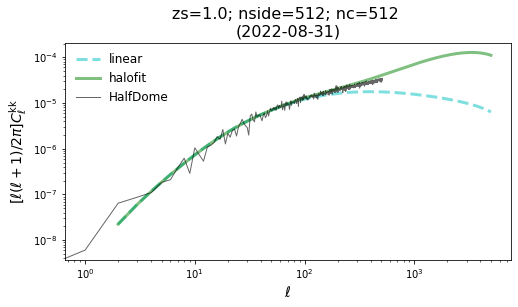

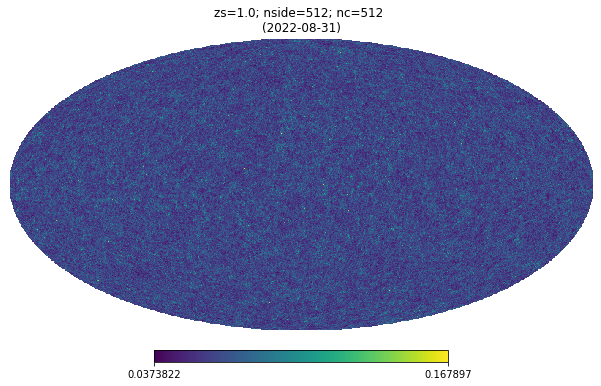

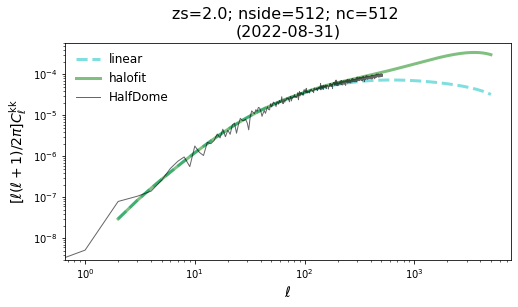

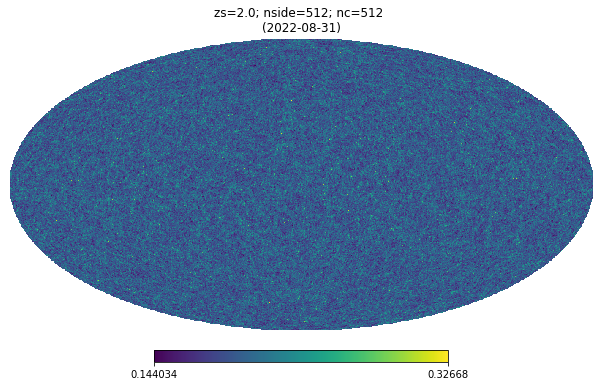

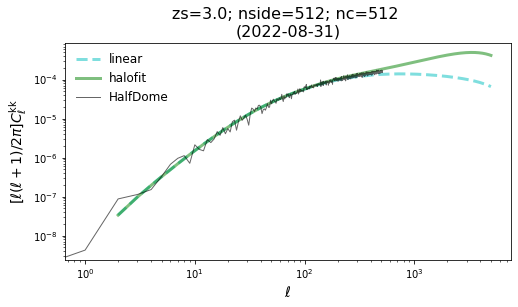

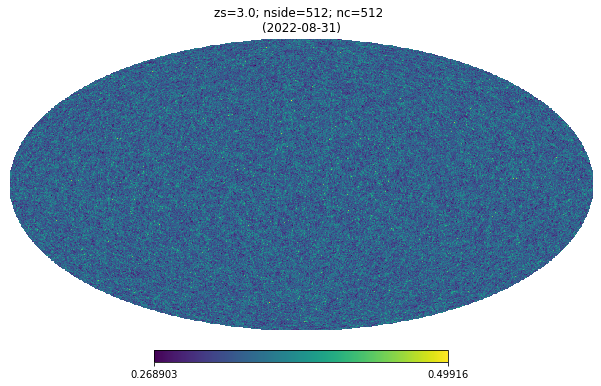

In [52]:
for zs in (1,2,3):
    gen_comp(zs)